In [1]:
#
# General Power Theory - Thevenin Instrument
#
# File:            gpt_thevenin_instrument.ipynb
# Author:          Thomas Gwasira (tomgwasira@gmail.com), MLT Power
# Date:            February 2020
#
# Functionality:
# This is development code for implementation of the General Power Theory algorithm
# on the Thevenin instrument using the Raspberry Pi on the instrument.
#
# Raw, sampled ADC data is obtained from the on-board PIC24HJ128GP206 over an I2C line.
#

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from smbus2 import SMBus, i2c_msg

In [4]:
def get_int16(lower_byte, higher_byte):
    '''
    Combines two bytes where one is the most significant byte and the other is the least significant byte of a 16-bit integer.

    Parameters:
    @param higher_byte: Most significant byte of 16-bit integer
    @param lower_byte: Least signinficant byte of 16-bit integer
    
    @rtype: int
    @returns: 16 bit integer which is a combination of the given two bytes
    '''
    return ((higher_byte & 0xFF) << 8) | (lower_byte & 0xFF)

In [5]:
def removeDCComponent(x):
    '''
    Uses Discrete Time Fourier Transform formula to obtain the normalized complex value of the signal's spectrum at frequency 0
    and then removes that component from the given signal.
    
    The normalization routine performed here for the Fourier Transform to obey Parseval's relation is based on the article:
    http://www.dspguide.com/ch10/7.htm    
    
    Parameters:
    @param x: Time domain signal whose frequency component is to be computed
    @param f: Frequency (Hz) of interest
    @param fs: Sample rate
    
    @rtype: ndarray
    @returns: Original signal with DC offset removed
    '''
    R = 0 # real part
    I = 0 # complex part
    
    for n in range(len(x)):
        R += x[n] * np.cos(2*np.pi*0*n)
        I += x[n] * np.sin(2*np.pi*0*n)
    
    X0 = (np.complex(R, I)/2)/(len(x)/2)
    x = x - np.abs(X0)
    
    return x

In [6]:
def quadratic_interpolate(a, b, c, b_pos):
    '''
    Performs quadratic interpolation for a set of three adjacent values to obtain location (x-coordinate) of peak
    
    @param a: Sample 1 of 3 adjacent samples to which parabola is to be fitted
    @param b: Sample 2 of 3 adjacent samples to which parabola is to be fitted
    @param c: Sample 3 of 3 adjacent samples to which parabola is to be fitted
    @param b_pos: Index of middle sample
    
    @rtype: double
    @returns: Non-discrete 'index' of peak
    '''
    
    return b_pos+(0.5*(a-c)/(a-(2*b)+c))

In [7]:
def compute_f0_acf(x, fs):
    '''
    Determines fundamental frequency of a signal using autocorrelation
    
    Parameters:
    @param x: signal whose fundamental frequency is to be determined
    @param fs: sampling frequency of signal x
    
    The ACF of the signal is not actually fully computed or stored to save on space and time.
    Instead, a state machine is used to detect the second peak in the ACF (first peak is the maximum and is always at 0). 
    
    The states are:
    STATE 0 : set threshold under which value we'll ignore the data. NEW STATE = 1
    STATE 1 : check if signal is above threshold AND slope of the signal is positive. If so, move to STATE 2.
    STATE 2 : check if slope of signal has become negative or zero. If so, peak has been found. Move to STATE 3.
    STATE 3 : exit state machine.
    
    @rtype: double
    @returns: Fundamental frequency (f0)
    '''
    
    thresh = 0
    f0 = 0
    STATE = 0
    sum = 0
    prev_sum = 0
    L = 0 # fundamental frequency period expressed in samples
    
    L_det = 0
    count = 0
    
    R = np.zeros(len(x))
    
    # Autocorrelation with peak detection
    for m in range(len(x)):
        prev_prev_sum = prev_sum
        prev_sum = sum
        sum = 0
        
        for n in range(len(x)-m):
            sum += x[n] * x[n+m] # not storing ACF in order to store memory
        
        # State machine to obtain three adjacent points around peak for quadratic interpolation
        if (STATE == 2 and (sum - prev_sum) <= 0): # if gradient change, obtain current and previous two values
            L = quadratic_interpolate(prev_prev_sum, prev_sum, sum, m-1)
            STATE = 3
            break
            
        if (STATE == 1 and (sum > thresh) and (sum - prev_sum) > 0):
            STATE = 2
            
        if (m == 0):
            thresh = sum * 0.5 # peaks to be detected are above half the first peak (maximum value of ACF)
            STATE = 1
            
    
    # Computing frequency in Hz
    f0 = fs/L
    
    if (f0 < 40 and f0 > 60):
        print('Fundamental frequency too far from 50 Hz!')
    
    return f0

In [8]:
def normalized_spectral_value(x, f, fs):
    '''
    Uses Discrete Time Fourier Transform formula to obtain the normalized complex value of the signal's spectrum at a particular
    frequency.
    
    The normalization routine performed here for the Fourier Transform to obey Parseval's relation is based on the article:
    http://www.dspguide.com/ch10/7.htm    
    
    Parameters:
    @param x: Time domain signal whose frequency component is to be computed
    @param f: Frequency (Hz) of interest
    @param fs: Sample rate
    
    @rtype: complex128
    @returns: Complex value of frequency component
    '''
    R = 0 # real part
    I = 0 # complex part
    frel = f/fs # relative frequency. Equation of DTFT actually uses cycles/sample not cycles/sec (i.e. Hz).
    
    for n in range(len(x)):
        R += x[n] * np.cos(2*np.pi*frel*n)
        I += x[n] * np.sin(2*np.pi*frel*n)
    
    X_f = np.complex(R, I)
    
    # Normalising
    if (f == 0): # for DFT if f corresponds to sample at 0 or sample at +/-N/2. Because DTFT is used here, there is no way of knowing what frequency is at N/2
        X_f = X_f/2
    X_f = X_f/(len(x)/2) # dividing all points in DTFT by N/2
    
    return  X_f

In [10]:
# --------------------------------------------------------
# Variables to be matched between Pi and PIC
# --------------------------------------------------------
DEVICE_ADDRESS = 0x30 # 7 bit address (will be left shifted to add the R/W bit)
BUFFER_SIZE = 256 # size of buffers storing measurement on PIC
NUMBER_OF_BUFFERS_TO_TRANSMIT = 7 # number of different types of buffers being transmitted over I2C from PIC
no_of_bytes = (NUMBER_OF_BUFFERS_TO_TRANSMIT * 2) + 2 # the additional 2 bytes are for error checking. A 'packet' of samples from each of the bytes is always wrapped in a 0 and 1.
CT_RATIO = 30
fs = 6400

# --------------------------------------------------------
# Other global variables
# --------------------------------------------------------

# --------------------------------------------------------
# Calibrations
# --------------------------------------------------------
V1_CALIB = 0.23089
V2_CALIB = 0.23089
V3_CALIB = 0.23089

I1_CALIB = CT_RATIO/291.6848485
I2_CALIB = CT_RATIO/291.6848485
I3_CALIB = CT_RATIO/291.6848485

sample_number_buffer = [None for x in range(BUFFER_SIZE)]
v1_buffer = [None for x in range(BUFFER_SIZE)]
v2_buffer = [None for x in range(BUFFER_SIZE)]
v3_buffer = [None for x in range(BUFFER_SIZE)]
i1_buffer = [None for x in range(BUFFER_SIZE)]
i2_buffer = [None for x in range(BUFFER_SIZE)]
i3_buffer = [None for x in range(BUFFER_SIZE)]

In [22]:
# --------------------------------------------------------
# Reading data from PICHJ128GP206
# --------------------------------------------------------
with SMBus(1) as bus:
    for i in xrange(0, BUFFER_SIZE):     
        # Read 17 bytes from PICHJ128GP206 device. This also sets a flag that tells the PIC to fill up the buffers until they are full then stop writing to the buffers to avoid overwriting any values
        msg = i2c_msg.read(DEVICE_ADDRESS, no_of_bytes)
        bus.i2c_rdwr(msg)
        data = list(msg)

        # data[0] is supposed to be 0 and is an error checking byte
        
        sample_number_buffer[i] = get_int16(data[1], data[2])
        v1_buffer[i] = get_int16(data[3], data[4]) * V1_CALIB # the read values are ADC values. Multiply by calibration values to make them voltage values
        v2_buffer[i] = get_int16(data[5], data[6]) * V2_CALIB
        v3_buffer[i] = get_int16(data[7], data[8]) * V3_CALIB
        i1_buffer[i] = get_int16(data[9], data[10]) * I1_CALIB
        i2_buffer[i] = get_int16(data[11], data[12]) * I2_CALIB
        i3_buffer[i] = get_int16(data[13], data[14]) * I3_CALIB
        
        # data[15] is supposed to be 1 and is also an error checking byte
        # Implement some type of error checking that waits for a 0 to start saving stuff to a buffer and makes sure
        # last element is a 1 otherwise it discards the whole corrupted set of samples and alerts user that something
        # is wrong with the communications (maybe add a value of None to the array).

    # Transmit message to indicate to PIC that Pi is done reading all buffers. PIC can start writing to buffers again
    msg = i2c_msg.write(DEVICE_ADDRESS, [0])
    bus.i2c_rdwr(msg)

('f0 for i1: ', 50.861012139156323)
('I1(f0): ', 5.6645505738956476)


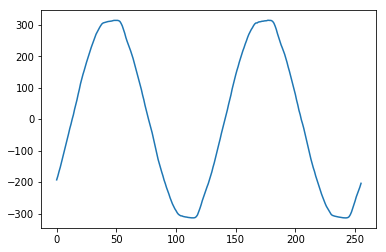

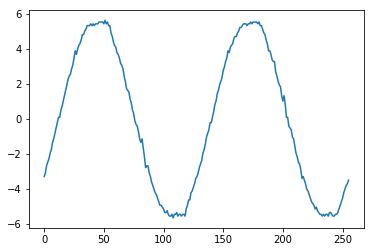

In [23]:
v1_buffer = removeDCComponent(v1_buffer)
plt.figure()
plt.plot(v1_buffer)

i1_buffer = removeDCComponent(i1_buffer) # remove offset i.e. make signal oscillate about 0
plt.figure()
plt.plot(i1_buffer)

f0_i1 = compute_f0_acf(i1_buffer, fs) # compute fundamental frequency of signal
print("f0 for i1: ", f0_i1)

I1_f0 = np.abs(normalized_spectral_value(i1_buffer,f0_i1, fs)) # compute magnitude of signal at fundamental frequency
print("I1(f0): ", I1_f0)